In [66]:
# let's download a pretrained version of AlexNet from torchvision
import torch
import torchvision
import matplotlib.pyplot as plt
import cbir
import numpy as np
import os
import pandas as pd
import math
import random

## Create Figures folder

In [67]:
path = "Figures/doc_ret/"

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory Figures/doc_ret/ failed


## Functions

In [68]:
def sort_MM(gdata):
    
    evaldb = []
    MMs = []
    
    for g in gdata:
        label = g["mark_label"]
        
        if label not in MMs:
            
            MMs.append(label)
            found = []
            
            for mark in gdata:
                if label == mark["mark_label"]:
                    
                    fname = mark["filename"].split(".")
                    found.append(fname[0] + "_" + str(mark["index"]) + "." + fname[1])
                else:
                    continue
            
            if len(found) > 1:
                MMPP = {
                    "mark_label": label,
                    "PPs": found
                }

                evaldb.append(MMPP)
    
    return evaldb

In [85]:
# Function to calculate the recall
def cal_metric(fname, gdata, ret_ids, retsize):
    
    acquired = 0
    total = 0
    
    # Get the index of the query
    query_index = fname.split("_")[3].split(".")[0]
    query = ""
    
    #print("query_index: " + str(query_index))
    
    # Get the mark label for the query
    for mark in gdata:
        #print(mark["index"])
        if int(query_index) == int(mark["index"]):
            query = mark["mark_label"]
            break
    
    # Find all the marks that have the same label
    for mark in gdata:
        # If labels match
        if query == mark["mark_label"]:
            # Add to total possible matches
            total += 1
            if int(query_index) == int(mark["index"]):
                # To account for the query itself
                total -= 1
            for ret_id in ret_ids:
                # Check if this match was recalled
                #print(ret_id)
                ret_index = int(ret_id.split("_")[3].split(".")[0])
                if ret_index == mark["index"]:
                    acquired += 1
                    if int(query_index) == ret_index: 
                        # To account for the query itself
                        acquired -= 1
    
    if total == 0:
        #print("This mark is unique")
        #print(fname)
        return 1
    else:
        recall = acquired/total
        precision = acquired/(retsize)
        
        if precision == 0 and recall == 0:
            #print("No matches")
            #print(fname)
            #print("There are " + str(total) + " possible matches")
            return(0,0)

        metrics = [precision, recall]
    
        return metrics

## Get list of mark images

In [70]:
#Location of images
folder_name = 'MMCroppedLogos'
names = []

for dirName, subdirList, fileList in os.walk(folder_name):
    for fname in fileList:
        print('\t%s' % fname)

        names.append(fname)
        
for x in range(0,7):
    names.pop(-1)
    
    
print(len(names))

	113_21_0095_275.jpg
	114_7_0070_576.jpg
	114_7_0029_350.jpg
	113_21_0092_256.jpg
	114_7_0037_407.jpg
	114_7_0075_650.jpg
	114_7_0071_617.jpg
	114_7_0078_738.jpg
	94_20_0035_41.jpg
	103_7_0026_179.jpg
	114_7_0044_546.jpg
	113_21_0087_232.jpg
	114_7_0070_565.jpg
	114_7_0071_642.jpg
	94_20_0105_142.jpg
	94_20_0027_11.jpg
	105_11_0076_759.jpg
	114_7_0037_406.jpg
	114_7_0077_712.jpg
	113_21_0100_331.jpg
	114_7_0071_635.jpg
	114_7_0037_392.jpg
	114_7_0030_356.jpg
	114_7_0036_387.jpg
	94_20_0105_126.jpg
	103_7_0043_196.jpg
	105_11_0076_761.jpg
	113_21_0099_328.jpg
	114_7_0076_680.jpg
	94_20_0080_74.jpg
	114_7_0038_447.jpg
	114_7_0071_613.jpg
	113_21_0057_219.jpg
	113_21_0096_280.jpg
	114_7_0042_475.jpg
	114_7_0070_561.jpg
	114_7_0077_705.jpg
	114_7_0043_509.jpg
	94_20_0036_51.jpg
	94_20_0105_122.jpg
	114_7_0070_580.jpg
	94_20_0036_52.jpg
	114_7_0071_621.jpg
	113_21_0099_313.jpg
	94_20_0028_26.jpg
	114_7_0036_384.jpg
	114_7_0043_528.jpg
	113_21_0089_247.jpg
	114_7_0071_624.jpg
	105_6_0052_210

## Load Gtruth

In [75]:
# Load ground truth
# Extract Groundtruth data

# Load up the markup co-ordinates
# Load the ground truth csv file
via_export = pd.read_csv("gtruthDB.csv")
factor = 1
gdata = []
# Cycle through each instance of a mark
for x in range(via_export.shape[0]):
    
    # Extract the file name and region properties
    data = via_export.iloc[x]
    #index = data.Unnamed
    filename = data.filename
    mark_label = data.mark_label
    mark = {
        "index":x,
        "filename":filename,
        "mark_label":mark_label
    }
    
    gdata.append(mark)
    
for data in gdata:
    print(data)

{'index': 0, 'filename': '94_20_0026.jpg', 'mark_label': 'GIB'}
{'index': 1, 'filename': '94_20_0026.jpg', 'mark_label': 'GFP'}
{'index': 2, 'filename': '94_20_0026.jpg', 'mark_label': 'WC'}
{'index': 3, 'filename': '94_20_0026.jpg', 'mark_label': 'WC'}
{'index': 4, 'filename': '94_20_0027.jpg', 'mark_label': 'P'}
{'index': 5, 'filename': '94_20_0027.jpg', 'mark_label': 'DC'}
{'index': 6, 'filename': '94_20_0027.jpg', 'mark_label': 'IA'}
{'index': 7, 'filename': '94_20_0027.jpg', 'mark_label': 'IV'}
{'index': 8, 'filename': '94_20_0027.jpg', 'mark_label': 'VR'}
{'index': 9, 'filename': '94_20_0027.jpg', 'mark_label': 'VR'}
{'index': 10, 'filename': '94_20_0027.jpg', 'mark_label': 'VR'}
{'index': 11, 'filename': '94_20_0027.jpg', 'mark_label': 'P'}
{'index': 12, 'filename': '94_20_0027.jpg', 'mark_label': 'DC'}
{'index': 13, 'filename': '94_20_0027.jpg', 'mark_label': 'P'}
{'index': 14, 'filename': '94_20_0027.jpg', 'mark_label': 'IC'}
{'index': 15, 'filename': '94_20_0027.jpg', 'mark_l

## Set up DB

In [76]:
# Init database
MMDataSet = cbir.Dataset(folder="MMCroppedLogos")

## Random Base line (Zero skill)


 For 1documents
The average precision: 0.009566210423057964
The average recall: 0.0019838169635398987
Total number of instances with recall = 0: 96
0.0019838169635398987
0

 For 6documents
The average precision: 0.007204358056570524
The average recall: 0.004849260919101361
Total number of instances with recall = 0: 78
0.004849260919101361
0.0019838169635398987

 For 11documents
The average precision: 0.0067398773381858595
The average recall: 0.007970003366747955
Total number of instances with recall = 0: 71
0.007970003366747955
0.004849260919101361

 For 16documents
The average precision: 0.006028125765967488
The average recall: 0.014328201618709294
Total number of instances with recall = 0: 71
0.014328201618709294
0.007970003366747955

 For 21documents
The average precision: 0.007807383188982578
The average recall: 0.02928776587630209
Total number of instances with recall = 0: 60
0.02928776587630209
0.014328201618709294

 For 26documents
The average precision: 0.008296856775763388
Th


 For 571documents
The average precision: 0.007363055848001481
The average recall: 0.7342986314778128
Total number of instances with recall = 0: 2
0.7342986314778128
0.7128608380493568

 For 601documents
The average precision: 0.00736076101546174
The average recall: 0.7925766004792751
Total number of instances with recall = 0: 0
0.7925766004792751
0.7342986314778128

 For 631documents
The average precision: 0.007307146549367734
The average recall: 0.8232945546053324
Total number of instances with recall = 0: 0
0.8232945546053324
0.7925766004792751

 For 661documents
The average precision: 0.0074289076603346604
The average recall: 0.8726724720055072
Total number of instances with recall = 0: 0
0.8726724720055072
0.8232945546053324

 For 691documents
The average precision: 0.00735336028193589
The average recall: 0.8967930450735961
Total number of instances with recall = 0: 0
0.8967930450735961
0.8726724720055072

 For 721documents
The average precision: 0.007352671243786588
The average r

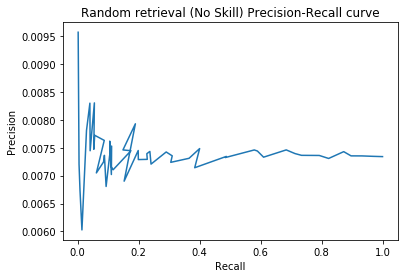

In [86]:
# Calculate average recall and precision for each unique case, EXCLUDE THE QUERY IN EVALUATION

#Lists for precision-recall curve
rando_precision = []
rando_recall = []

# Sort the ground data
evaldb = sort_MM(gdata)
check_new = 0
check_old = 0
r = 1

while check_new != 1:
    
    precision = []
    recall = []
    marks = []
    miss = 0
    # Calculate the metrics
    for x in evaldb:

        marks.append(x["mark_label"])    
        metrics = []

        #Extract files
        files = x["PPs"]
        # Cycle files
        for f in files:
            # Open file
            img = MMDataSet.read_image(f)
            # Get scores and list
            img_id = random.sample(names, r)

            # Calculate the metric
            metric = cal_metric(f, gdata, img_id, r)
            metrics.append(metric)

        av = np.sum(metrics, axis = 0)/len(files)
        #print(av)
        #print(x["mark_label"])
        precision.append(av[0])
        recall.append(av[1])

        if av[1] == 0:
            miss += 1

    # Calculate the average overall instances
    marks.append("average")
    av_p = np.sum(precision)/len(precision)
    av_r = np.sum(recall)/len(precision)
    
    precision.append(av_p)
    recall.append(av_r)

    print("\n For " + str(r) + "documents")
    print("The average precision: " + str(av_p))
    print("The average recall: " + str(av_r))
    print("Total number of instances with recall = 0: " + str(miss))

    # Append to lists
    rando_precision.append(av_p)
    rando_recall.append(av_r)
    
    check_new = av_r

    print(check_new)
    print(check_old)

    if r == 751:
        r = 775
    elif r > 300:
        r += 30
    elif r > 200:
        r += 20
    elif r > 100:
        r += 10
    else:
        r += 5
    
    check_old = check_new
    
plt.plot(rando_recall, rando_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Random retrieval (No Skill) Precision-Recall curve")
plt.savefig(path+ "rando.svg")
plt.show()

## Ideal Precision-recall curve


 For 1documents
The average precision: 1.0
The average recall: 0.47703688494330465
Total number of instances with recall = 0: 0
1.0
0

 For 6documents
The average precision: 0.5676100628930817
The average recall: 0.8650514983390735
Total number of instances with recall = 0: 0
0.5676100628930817
1.0

 For 11documents
The average precision: 0.4073756432246999
The average recall: 0.9402666208693137
Total number of instances with recall = 0: 0
0.4073756432246999
0.5676100628930817

 For 16documents
The average precision: 0.32547169811320753
The average recall: 0.9810270471524049
Total number of instances with recall = 0: 0
0.32547169811320753
0.4073756432246999

 For 21documents
The average precision: 0.2610062893081761
The average recall: 0.9933104631217838
Total number of instances with recall = 0: 0
0.2610062893081761
0.32547169811320753

 For 26documents
The average precision: 0.21480406386066767
The average recall: 0.9967409948542024
Total number of instances with recall = 0: 0
0.214

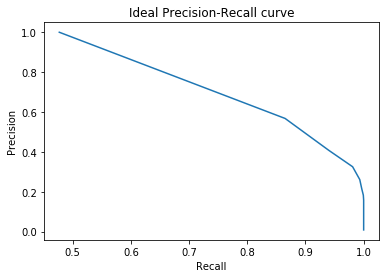

In [83]:
# Calculate average recall and precision for each unique case, EXCLUDE THE QUERY IN EVALUATION

#Lists for precision-recall curve
ideal_precision = []
ideal_recall = []

# Sort the ground data
evaldb = sort_MM(gdata)
check_new = 1
check_old = 0
r = 1

while check_new >= 0.009:
    
    precision = []
    recall = []
    marks = []
    miss = 0
    # Calculate the metrics
    for x in evaldb:

        marks.append(x["mark_label"])    
        metrics = []

        #Extract files
        files = x["PPs"]
        # Cycle files
        for f in files:
            success = []
            failure = []

            for y in range(int(r)):
                if y < (len(files)-1):
                    success.append(1)
                else:
                    failure.append(0)

            #Calculate the metrics
            p = len(success)/(len(success)+len(failure))
            re = len(success)/(len(files)-1)
            
            metric = [p,re]
            metrics.append(metric)

        av = np.sum(metrics, axis = 0)/len(files)
        #print(av)
        #print(x["mark_label"])
        precision.append(av[0])
        recall.append(av[1])

        if av[1] == 0:
            miss += 1

    # Calculate the average overall instances
    marks.append("average")
    av_p = np.sum(precision)/len(precision)
    av_r = np.sum(recall)/len(precision)
    
    precision.append(av_p)
    recall.append(av_r)

    print("\n For " + str(r) + "documents")
    print("The average precision: " + str(av_p))
    print("The average recall: " + str(av_r))
    print("Total number of instances with recall = 0: " + str(miss))

    # Append to lists
    ideal_precision.append(av_p)
    ideal_recall.append(av_r)
    
    check_new = av_p

    print(check_new)
    print(check_old)

    if r == 756:
        r = 775
    elif r > 300:
        r += 30
    elif r > 200:
        r += 20
    elif r > 100:
        r += 10
    else:
        r += 5
    
    check_old = check_new
    
plt.plot(ideal_recall, ideal_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Ideal Precision-Recall curve")
plt.savefig(path+ "ideal.png")
plt.show()

## Testing conv autoencoder

In [87]:
#Init conv auto DB and index
MMDB_cAutoEnc = cbir.Database(MMDataSet, encoder=cbir.encoders.cOmniAutoEncoder())
MMDB_cAutoEnc.index()


Generating index...
Reshaping 113_21_0099_326.jpg07.589600
Reshaping 113_21_0100_330.jpg07.501401
Reshaping 114_7_0044_538.jpg:03.564121
Reshaping 94_20_0026_2.jpg00:01.300470
Reshaping 94_20_0026_3.jpg00:01.295527
Reshaping 94_20_0080_102.jpg:00.762570
Reshaping 94_20_0080_68.jpg0:00.740920
Reshaping 94_20_0080_72.jpg0:00.709233
Reshaping 94_20_0080_76.jpg0:00.677508
Reshaping 94_20_0080_78.jpg0:00.662125
Reshaping 94_20_0080_81.jpg0:00.639232
Reshaping 94_20_0080_83.jpg0:00.623932
Reshaping 94_20_0080_87.jpg0:00.590988
Reshaping 94_20_0080_89.jpg0:00.574929
Reshaping 94_20_0105_144.jpg:00.148462


15
15
[0.2, 0.5]


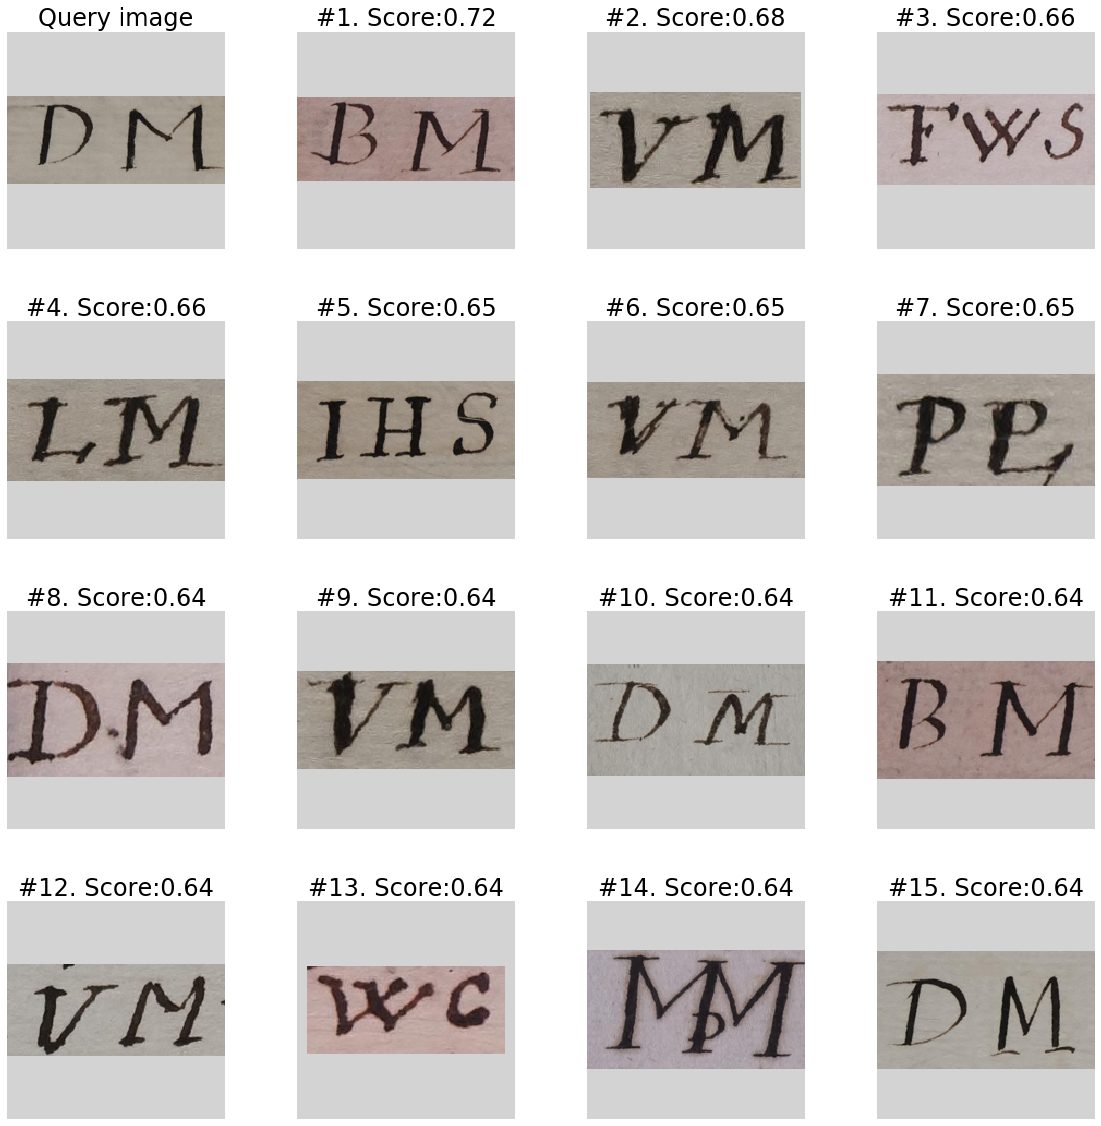

In [88]:
f = "103_7_0023_163.jpg"
r = 15
img = MMDataSet.read_image(f)
# Get scores and list
scores = MMDB_cAutoEnc.retrieve(f)
img_id = list(scores.keys())[1:r+1]

print(len(img_id))

print(len(img_id))

MMDB_cAutoEnc.show_results_grid(f, scores, figsize=(20, 20), n=15)
metric = cal_metric(f, gdata, img_id, r)
print(metric)

0.07463584072340924
0

 For 1documents
The average precision: 0.2783558783564283
The average recall: 0.07463584072340924
Total number of instances with recall = 0: 48
0.19076182418990326
0.07463584072340924

 For 6documents
The average precision: 0.14098479350861903
The average recall: 0.19076182418990326
Total number of instances with recall = 0: 32
0.24115788134715857
0.19076182418990326

 For 11documents
The average precision: 0.1028812111742283
The average recall: 0.24115788134715857
Total number of instances with recall = 0: 31
0.2890952452209825
0.24115788134715857

 For 16documents
The average precision: 0.0837821640195912
The average recall: 0.2890952452209825
Total number of instances with recall = 0: 27
0.30824527038434657
0.2890952452209825

 For 21documents
The average precision: 0.07031954067360606
The average recall: 0.30824527038434657
Total number of instances with recall = 0: 26
0.33712820329765114
0.30824527038434657

 For 26documents
The average precision: 0.06210481

0.9172414425299615
0.9028011594498364

 For 601documents
The average precision: 0.008431126981246253
The average recall: 0.9172414425299615
Total number of instances with recall = 0: 2
0.9271514075910071
0.9172414425299615

 For 631documents
The average precision: 0.008183533937899435
The average recall: 0.9271514075910071
Total number of instances with recall = 0: 2
0.9431384232061871
0.9271514075910071

 For 661documents
The average precision: 0.007986043961696812
The average recall: 0.9431384232061871
Total number of instances with recall = 0: 1
0.9613611166592014
0.9431384232061871

 For 691documents
The average precision: 0.007825912894658464
The average recall: 0.9613611166592014
Total number of instances with recall = 0: 1
0.9733923170365762
0.9613611166592014

 For 721documents
The average precision: 0.007634126873871757
The average recall: 0.9733923170365762
Total number of instances with recall = 0: 1
0.9937595413901452
0.9733923170365762

 For 751documents
The average precis

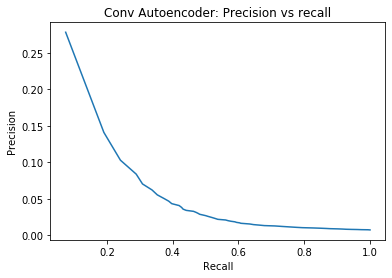

In [90]:
# Calculate average recall and precision for each unique case, EXCLUDE THE QUERY IN EVALUATION

#Lists for precision-recall curve
conv_precision = []
conv_recall = []

# Sort the ground data
evaldb = sort_MM(gdata)
check_new = 0
check_old = 0
r = 1

while check_new != 1:
    
    precision = []
    recall = []
    marks = []
    miss = 0
    # Calculate the metrics
    for x in evaldb:

        marks.append(x["mark_label"])    
        metrics = []

        #Extract files
        files = x["PPs"]
        # Cycle files
        for f in files:
            # Open file
            img = MMDataSet.read_image(f)
            # Get scores and list
            scores = MMDB_cAutoEnc.retrieve(f)
            img_id = list(scores.keys())[1:1+r]

            # Calculate the metric
            metric = cal_metric(f, gdata, img_id, r)
            metrics.append(metric)

        av = np.sum(metrics, axis = 0)/len(files)
        #print(av)
        #print(x["mark_label"])
        precision.append(av[0])
        recall.append(av[1])

        if av[1] == 0:
            miss += 1

    # Calculate the average overall instances
    marks.append("average")
    av_p = np.sum(precision)/len(precision)
    av_r = np.sum(recall)/len(precision)
    
    precision.append(av_p)
    recall.append(av_r)
    
    check_new = av_r    
    check_old = check_new

    print("\n For " + str(r) + "documents")
    print("The average precision: " + str(av_p))
    print("The average recall: " + str(av_r))
    print("Total number of instances with recall = 0: " + str(miss))

    if r > 300:
        r += 30
    elif r > 200:
        r += 20
    elif r > 100:
        r += 10
    else:
        r += 5    
        
    print(check_new)
    print(check_old)
    
    # Append to lists
    conv_precision.append(av_p)
    conv_recall.append(av_r)
    
plt.plot(conv_recall, conv_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Conv Autoencoder: Precision vs recall")
plt.savefig(path + "cApr.svg")
plt.show()

## Testing denoisingconv autoencoder

In [91]:
# Set up denoising conv DB
MMDB_DcAutoEnc = cbir.Database(MMDataSet, encoder=cbir.encoders.DcOmniAutoEncoder())
MMDB_DcAutoEnc.index()


Generating index...
Reshaping 113_21_0099_326.jpg06.160843
Reshaping 113_21_0100_330.jpg06.101154
Reshaping 114_7_0044_538.jpg:02.857004
Reshaping 94_20_0026_2.jpg00:01.053506
Reshaping 94_20_0026_3.jpg00:01.050435
Reshaping 94_20_0080_102.jpg:00.623860
Reshaping 94_20_0080_68.jpg0:00.606200
Reshaping 94_20_0080_72.jpg0:00.579877
Reshaping 94_20_0080_76.jpg0:00.553347
Reshaping 94_20_0080_78.jpg0:00.540760
Reshaping 94_20_0080_81.jpg0:00.521514
Reshaping 94_20_0080_83.jpg0:00.509481
Reshaping 94_20_0080_87.jpg0:00.482759
Reshaping 94_20_0080_89.jpg0:00.469702
Reshaping 94_20_0105_144.jpg:00.121044


0.07472231323393956
0

 For 1documents
The average precision: 0.27938704129344466
The average recall: 0.07472231323393956
Total number of instances with recall = 0: 47
0.20260402517457834
0.07472231323393956

 For 6documents
The average precision: 0.144742060953906
The average recall: 0.20260402517457834
Total number of instances with recall = 0: 31
0.24111220953954604
0.20260402517457834

 For 11documents
The average precision: 0.10110093793673004
The average recall: 0.24111220953954604
Total number of instances with recall = 0: 30
0.27568395018168834
0.24111220953954604

 For 16documents
The average precision: 0.08122526058732073
The average recall: 0.27568395018168834
Total number of instances with recall = 0: 28
0.29215951716480665
0.27568395018168834

 For 21documents
The average precision: 0.06757353337572461
The average recall: 0.29215951716480665
Total number of instances with recall = 0: 28
0.3080048493336066
0.29215951716480665

 For 26documents
The average precision: 0.05912

0.897939853265191
0.8703731769932881

 For 601documents
The average precision: 0.008406754510994395
The average recall: 0.897939853265191
Total number of instances with recall = 0: 2
0.9114987753606287
0.897939853265191

 For 631documents
The average precision: 0.008188570489685248
The average recall: 0.9114987753606287
Total number of instances with recall = 0: 2
0.9271670409622117
0.9114987753606287

 For 661documents
The average precision: 0.007998619738882986
The average recall: 0.9271670409622117
Total number of instances with recall = 0: 2
0.9401524246115328
0.9271670409622117

 For 691documents
The average precision: 0.007790955896201769
The average recall: 0.9401524246115328
Total number of instances with recall = 0: 2
0.9676445611437668
0.9401524246115328

 For 721documents
The average precision: 0.007633344777633287
The average recall: 0.9676445611437668
Total number of instances with recall = 0: 1
0.9929194435908585
0.9676445611437668

 For 751documents
The average precision

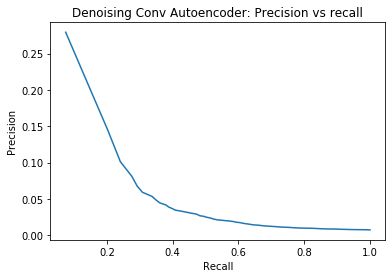

In [92]:
# Calculate average recall and precision for each unique case, EXCLUDE THE QUERY IN EVALUATION

#Lists for precision-recall curve
deco_precision = []
deco_recall = []

# Sort the ground data
evaldb = sort_MM(gdata)
check_new = 0
check_old = 0
r = 1

while check_new != 1:
    
    precision = []
    recall = []
    marks = []
    miss = 0
    # Calculate the metrics
    for x in evaldb:

        marks.append(x["mark_label"])    
        metrics = []

        #Extract files
        files = x["PPs"]
        # Cycle files
        for f in files:
            # Open file
            img = MMDataSet.read_image(f)
            # Get scores and list
            scores =  MMDB_DcAutoEnc.retrieve(f)
            img_id = list(scores.keys())[1:1+r]

            # Calculate the metric
            metric = cal_metric(f, gdata, img_id, r)
            metrics.append(metric)

        av = np.sum(metrics, axis = 0)/len(files)
        #print(av)
        #print(x["mark_label"])
        precision.append(av[0])
        recall.append(av[1])

        if av[1] == 0:
            miss += 1

    # Calculate the average overall instances
    marks.append("average")
    av_p = np.sum(precision)/len(precision)
    av_r = np.sum(recall)/len(precision)
    
    precision.append(av_p)
    recall.append(av_r)
    
    check_new = av_r

    print(check_new)
    print(check_old)
    
    check_old = check_new

    print("\n For " + str(r) + "documents")
    print("The average precision: " + str(av_p))
    print("The average recall: " + str(av_r))
    print("Total number of instances with recall = 0: " + str(miss))
    
    if r > 300:
        r += 30
    elif r > 200:
        r += 20
    elif r > 100:
        r += 10
    else:
        r += 5

    # Append to lists
    deco_precision.append(av_p)
    deco_recall.append(av_r)
    
plt.plot(deco_recall, deco_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Denoising Conv Autoencoder: Precision vs recall")
plt.savefig(path + "deCApr.svg")
plt.show()

## Testing AlexNet encoder

In [93]:
# Set up the AlexNet DB
MMDB_AlexImEmb = cbir.Database(MMDataSet, encoder=cbir.encoders.AlexNet())
MMDB_AlexImEmb.index()


Generating index...
Reshaping 113_21_0099_326.jpg20.544433
Reshaping 113_21_0100_330.jpg20.326078
Reshaping 114_7_0044_538.jpg:10.892626
Reshaping 94_20_0026_2.jpg00:04.294150
Reshaping 94_20_0026_3.jpg00:04.273528
Reshaping 94_20_0080_102.jpg:02.520935
Reshaping 94_20_0080_68.jpg0:02.441183
Reshaping 94_20_0080_72.jpg0:02.332785
Reshaping 94_20_0080_76.jpg0:02.223466
Reshaping 94_20_0080_78.jpg0:02.170354
Reshaping 94_20_0080_81.jpg0:02.090549
Reshaping 94_20_0080_83.jpg0:02.036646
Reshaping 94_20_0080_87.jpg0:01.928332
Reshaping 94_20_0080_89.jpg0:01.874038
Reshaping 94_20_0105_144.jpg:00.485468



 For 1documents
The average precision: 0.2360567802416154
The average recall: 0.055549146057488084
Total number of instances with recall = 0: 55
0.055549146057488084
0

 For 6documents
The average precision: 0.12680895102982956
The average recall: 0.15352840751932012
Total number of instances with recall = 0: 41
0.15352840751932012
0.055549146057488084

 For 11documents
The average precision: 0.09554536102374935
The average recall: 0.20672274195327073
Total number of instances with recall = 0: 37
0.20672274195327073
0.15352840751932012

 For 16documents
The average precision: 0.07697345961314576
The average recall: 0.23082281109309008
Total number of instances with recall = 0: 34
0.23082281109309008
0.20672274195327073

 For 21documents
The average precision: 0.0678898492201234
The average recall: 0.2692936722949583
Total number of instances with recall = 0: 31
0.2692936722949583
0.23082281109309008

 For 26documents
The average precision: 0.06149350933284615
The average recall: 0.297


 For 601documents
The average precision: 0.009105803477207474
The average recall: 0.9550261879379754
Total number of instances with recall = 0: 1
0.9550261879379754
0.9501212503007227

 For 631documents
The average precision: 0.00876160204153525
The average recall: 0.9659505604959243
Total number of instances with recall = 0: 0
0.9659505604959243
0.9550261879379754

 For 661documents
The average precision: 0.008412259850644314
The average recall: 0.9732662998917254
Total number of instances with recall = 0: 0
0.9732662998917254
0.9659505604959243

 For 691documents
The average precision: 0.008103500525793264
The average recall: 0.9853295419743957
Total number of instances with recall = 0: 0
0.9853295419743957
0.9732662998917254

 For 721documents
The average precision: 0.007819529424287949
The average recall: 0.9925356923452207
Total number of instances with recall = 0: 0
0.9925356923452207
0.9853295419743957

 For 751documents
The average precision: 0.00754710737277571
The average re

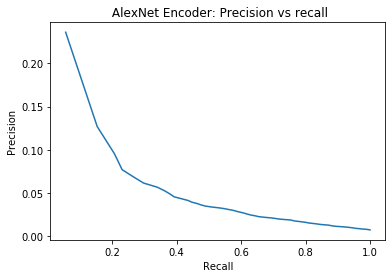

In [94]:
# Calculate average recall and precision for each unique case, EXCLUDE THE QUERY IN EVALUATION
# Save into a CSV

alex_precision = []
alex_recall = []

# Sort the ground data
evaldb = sort_MM(gdata)
check_new = 0
check_old = 0
r = 1

while check_new != 1:
    
    precision = []
    recall = []
    marks = []
    miss = 0
    # Calculate the metrics
    for x in evaldb:

        marks.append(x["mark_label"])    
        metrics = []

        #Extract files
        files = x["PPs"]
        # Cycle files
        for f in files:
            # Open file
            img = MMDataSet.read_image(f)
            # Get scores and list
            scores = MMDB_AlexImEmb.retrieve(f)
            img_id = list(scores.keys())[1:1+r]

            # Calculate the metric
            metric = cal_metric(f, gdata, img_id, r)
            metrics.append(metric)

        av = np.sum(metrics, axis = 0)/len(files)
        
        #print(av)
        #print(x["mark_label"])
        precision.append(av[0])
        recall.append(av[1])

        if av[1] == 0:
            miss += 1

    # Calculate the average overall instances
    marks.append("average")
    av_p = np.sum(precision)/len(precision)
    av_r = np.sum(recall)/len(precision)
    
    precision.append(av_p)
    recall.append(av_r)

    print("\n For " + str(r) + "documents")
    print("The average precision: " + str(av_p))
    print("The average recall: " + str(av_r))
    print("Total number of instances with recall = 0: " + str(miss))

    # Append to lists
    alex_precision.append(av_p)
    alex_recall.append(av_r)
    
    check_new = av_r

    print(check_new)
    print(check_old)

    if r > 300:
        r += 30
    elif r > 200:
        r += 20
    elif r > 100:
        r += 10
    else:
        r += 5
    
    check_old = check_new
    
plt.plot(alex_recall, alex_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(" AlexNet Encoder: Precision vs recall")
plt.savefig(path + "alexpr.svg")
plt.show()

## Comparing results

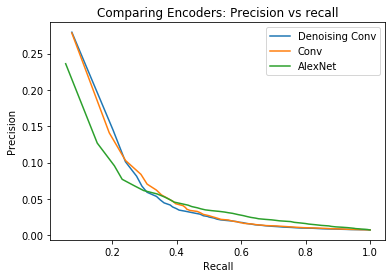

In [95]:
plt.plot(deco_recall, deco_precision, label="Denoising Conv")
plt.plot(conv_recall, conv_precision, label="Conv")
plt.plot(alex_recall, alex_precision, label="AlexNet")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Comparing Encoders: Precision vs recall")
plt.savefig(path + "compare_pr.svg")
plt.show()

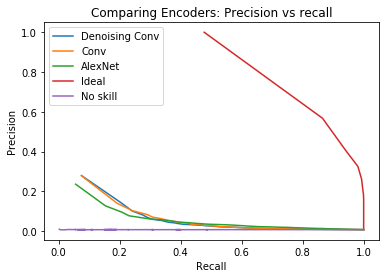

In [96]:
plt.plot(deco_recall, deco_precision, label="Denoising Conv")
plt.plot(conv_recall, conv_precision, label="Conv")
plt.plot(alex_recall, alex_precision, label="AlexNet")
plt.plot(ideal_recall, ideal_precision, label="Ideal")
plt.plot(rando_recall, rando_precision, label="No skill")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Comparing Encoders: Precision vs recall")
plt.savefig(path + "compare_irpr.svg")
plt.show()
